# Working with Probes 


probeinterface is a tool to handle the design of the probe layout, that will be used by all modern spike sorting algorithms. Indeed, since spike sorters are making use of the spatial positions of the channels to reconstruct the extracellular waveforms elicited during the spike of a single cell, it is crucial to know where channels are located. If you are lucky, then such a probe layout is already available, and you can use it instantaneously (e.g. `spikeinterface.extractors.read_spikeglx()`). But most of the time, depending on your recording setup/probe, you need to create one. In such a file, you must specify what your channels are, where they are in space, and what is the mapping between your recording file and the recording setup.

For this tutorial and exercise feel free to have a look at

  * [probeinterface documentation](https://probeinterface.readthedocs.io/en/main/)
  * [probeinterface examples](https://probeinterface.readthedocs.io/en/main/examples/index.html)


In [1]:
%matplotlib inline
# %matplotlib widget

In [2]:
# import probeinterface and spikeinterface (core module)
import probeinterface as pi
import spikeinterface as si

# import for dataframe and vector interaction
import numpy as np 
import pandas as pd

# import plotting libraries
from probeinterface.plotting import plot_probe
import matplotlib.pyplot as plt

## Getting an already implemented Probe (e.g. from the Cambridge Neurotech catalog)

In this case we just need to specify a `manufacturer` and a `probe_name` in order to have probeinterface automatically 
get the probe.
* See the currently available probes in the [probeinterface_library](https://github.com/SpikeInterface/probeinterface_library)
* If you don't see your lab's probe. Help us out and submit a probe design with the knowledge gained from this workshop!!


#### Let's start by grabbing a probe from Cambridge Neurotech and looking at the number of channels and shanks it has!

In [3]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H6'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

ASSY-236-H6 - cambridgeneurotech - 64ch - 2shanks


#### Next, we can plot our probe by using the convenient plotting functions within probeinterface's `plotting` submodule.

(<matplotlib.collections.PolyCollection at 0x72e28023be30>,
 <matplotlib.collections.PolyCollection at 0x72e2681bd040>)

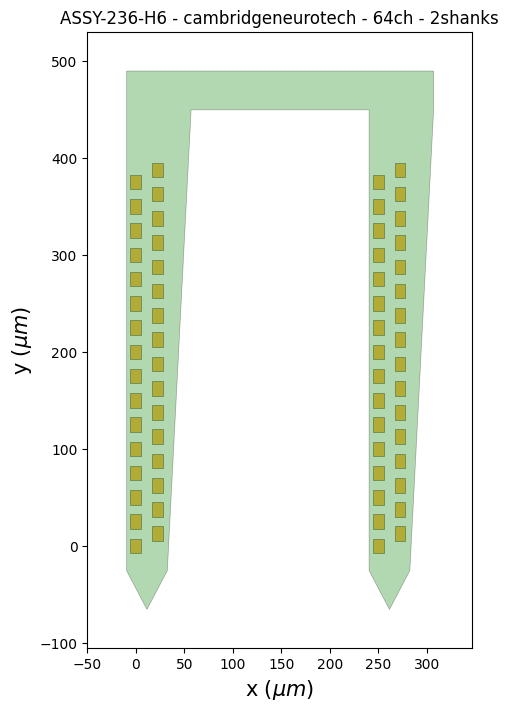

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
plot_probe(probe, ax=ax)
# plot_probe(probe, with_contact_id=True)

## `contact_ids` are the actual electrode contacts on the Probe itself

By setting `with_contact_id=True` in our `plot_probe` function we are able to display the `contact_ids` of the probe. These are the numbers that you find in the catalog and correspond
to the actual location in space. **Importantly** these are not the numbers that appear in the recording software. This is a real important point so let's dig into that!

(<matplotlib.collections.PolyCollection at 0x72e25d69e840>,
 <matplotlib.collections.PolyCollection at 0x72e25d692bd0>)

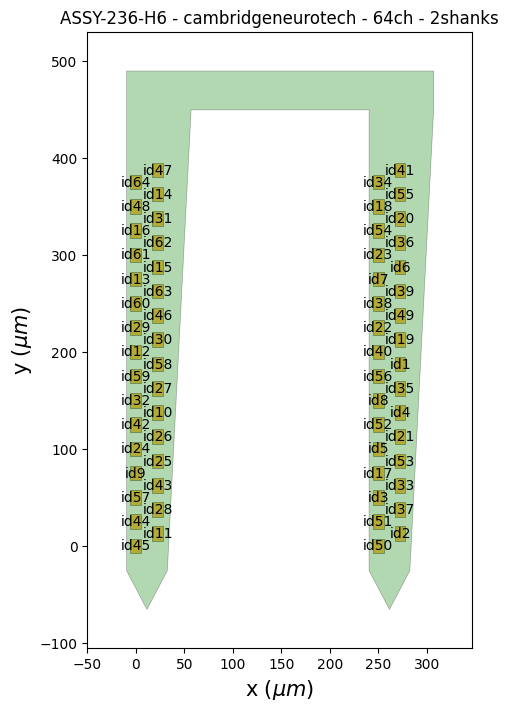

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
plot_probe(probe, ax=ax, with_contact_id=True)

## Wiring to the device! (aka pathway or mapping)

In order to go from the probe to the actual recording data requires us to map between the probe, any adaptors, and the recording equipment. Luckily for us probeinterface allows us to do this wiring automatically (for a subset of probes)!

To see the currently available pathways we use the `get_available_pathways()` function. It's important to notice that the pathway has multiple components. We have the probe which for Cambridge Neurotech begins with `ASSY` followed by either the headstage or an adaptor and then headstage (`Adpt` for adaptor and `RHD` are the commonly used Intan headstages). The components of the pathway are seperated by `>`.

In [6]:
print(pi.get_available_pathways())

['H32>RHD2132', 'ASSY-156>RHD2164', 'ASSY-116>RHD2132', 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164', 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132', 'cambridgeneurotech_mini-amp-64']


Now let's wire our probe to our headstage recording equipment. Let's use `cambridgeneurotech_mini-amp-64` and then see what our probe looks like now!

In [7]:
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
print(probe)

ASSY-236-H6 - cambridgeneurotech - 64ch - 2shanks


So the probe doesn't look any different, but let's plot it. But now instead of looking at the `contact_ids` let's look at the `device_channel_indices` which are the numbers associated with the actual columns of your data!

(<matplotlib.collections.PolyCollection at 0x72e25cd0c4a0>,
 <matplotlib.collections.PolyCollection at 0x72e25cd39640>)

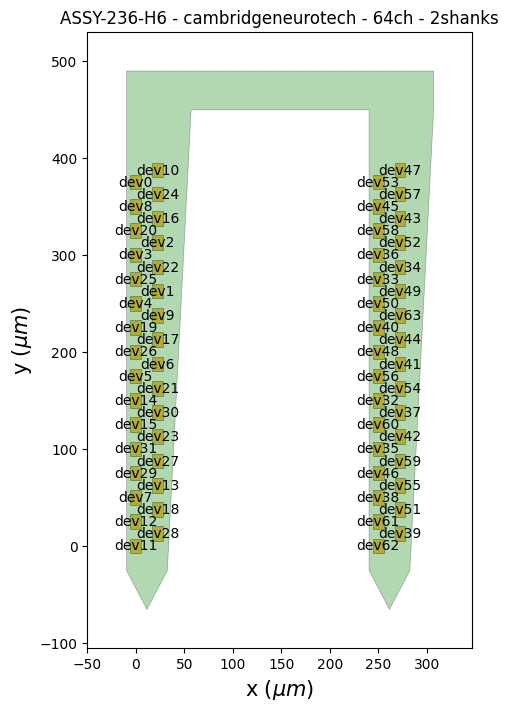

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
plot_probe(probe, ax=ax, with_device_index=True)

And so we can see that the `contact_ids` and the `device_channel_indices` are different let's plot them together!

To make it easier to view we will display just one shank!

(-10.0, 420.0)

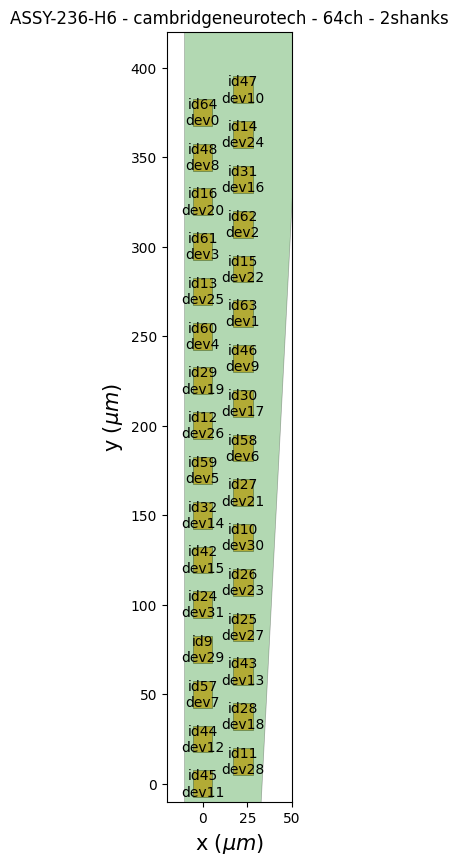

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True)
ax.set_xlim(-20,50)
ax.set_ylim(-10,420)

We can also view this information in a Pandas dataframe using the `to_dataframe()` function!

In [10]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,1,41
1,2,1,39
2,3,1,38
3,4,1,37
4,5,1,35
...,...,...,...
59,60,0,4
60,61,0,3
61,62,0,2
62,63,0,1


## Importantly, the probe slices the recording object

Each recording has a series of `channel_ids` that indicate the organization of the recording data matrix. To go from the contact positions (`contact_ids`) to the `channel_ids` we have the `device_channel_indices`. But 
since some recordings have additional channels (e.g. ADC data) when we attach a probe to a recording we actually make a slice of the recording object!. To show this we can easily make a simulated recording with 72 channels.

In [11]:
raw_recording = si.generate_recording(durations = [60.0], sampling_frequency=30_000.0, num_channels=72, seed=1776, set_probe=False)
raw_recording

SyntheticRecording: 72 channels - 30.0kHz - 1 segments - 1,800,000 samples - 60.00s (1.00 minutes) 
                    float32 dtype - 494.38 MiB

We know our probe only has 64 channels.

If we attach our probe to the recording using the `set_probe()` function we will see that our recording with the probe only has the 64 channels of our probe.
The original recording has been sliced!

In [12]:
raw_rec_w_probe = raw_recording.set_probe(probe)
print(raw_recording)
print(raw_rec_w_probe)

SyntheticRecording: 72 channels - 30.0kHz - 1 segments - 1,800,000 samples - 60.00s (1.00 minutes) 
                    float32 dtype - 494.38 MiB
SyntheticRecording: 64 channels - 30.0kHz - 1 segments - 1,800,000 samples - 60.00s (1.00 minutes) 
                    float32 dtype - 439.45 MiB


In [13]:
print("Raw Recording Channels\n", raw_recording.channel_ids, "\n")
print("Sliced Recording Channels\n", raw_rec_w_probe.channel_ids)

Raw Recording Channels
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] 

Sliced Recording Channels
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


Please also note that the probe is reversed to match the order of the recording!

In [14]:
probe_rec = raw_rec_w_probe.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "device_channel_indices"]]

,contact_ids,device_channel_indices
0,64,0
1,63,1
2,62,2
3,61,3
4,60,4
...,...,...
59,53,59
60,52,60
61,51,61
62,50,62


# Exercise Implement our own Probe!

Because not every probe and every wiring pathway is implemented (yet!) in probeinterface you may need to 1) make your own probe and 2) wire it manually. For the hands on portion of this session we will do this will a Neuronexus probe.

## Let's implement the neuronexus A1x32-Poly2-10mm-50s-177 probe manually


  * https://www.neuronexus.com/files/catalog/2021-Probe-Catalog.pdf



<img src="./neuronexus_A1xPoly32.png" width="400"/>



## Step 1 : constructing a probe from channel positions

using the `Probe()` object, some methods such as
  * `Probe.set_contacts()`
  * `Probe.set_contact_ids()`
and using the file **'A1x32-Poly2-10mm-50s-177.csv'** let's try to construct the probe as an exercise.

Once this is done, then plot it with `plot_probe()` and use the `with_contact_id=True` option.

To start let's just read in a dataframe with pandas of the probe!


In [15]:
df = pd.read_csv('A1x32-Poly2-10mm-50s-177.csv')
df

,contact_ids,x,y
0,1,0.0,300
1,2,0.0,350
2,3,0.0,400
3,4,0.0,450
4,5,0.0,500
5,6,0.0,550
6,7,0.0,600
7,8,0.0,650
8,9,0.0,700
9,10,0.0,750


Then we extract the positional data from the dataframe, create a probe, set those contacts and then give them a `contact_id`.

In [16]:
positions = df[['x', 'y']].values
probe = pi.Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 7.5})
probe.set_contact_ids(df['contact_ids'].values)
probe

Probe - 32ch - 1shanks

Now that we've created our probe object let's plot it and see how we did.

(<matplotlib.collections.PolyCollection at 0x72e25c3e7830>, None)

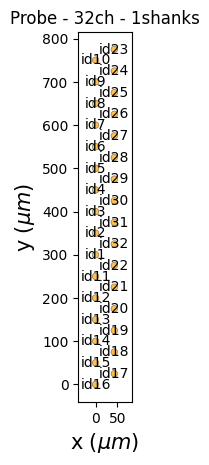

In [17]:
plot_probe(probe, with_contact_id=True)

### *Extra Feature: Step 1 : alternative method*

using the `Probe()` object, some methods such as
  * `Probe.from_dataframe()`


In [18]:
df = pd.read_csv('A1x32-Poly2-10mm-50s-177.csv')
df['contact_shapes'] = 'circle'
df['radius'] = 7.5

df.head()

,contact_ids,x,y,contact_shapes,radius
0,1,0.0,300,circle,7.5
1,2,0.0,350,circle,7.5
2,3,0.0,400,circle,7.5
3,4,0.0,450,circle,7.5
4,5,0.0,500,circle,7.5


In [19]:
probe = pi.Probe.from_dataframe(df)
probe

Probe - 32ch - 1shanks

(<matplotlib.collections.PolyCollection at 0x72e25c2e3b00>, None)

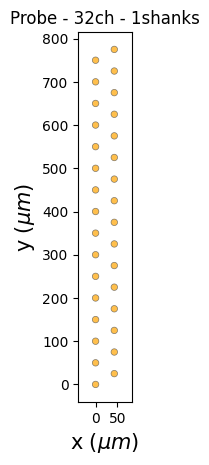

In [20]:
plot_probe(probe, with_contact_id=False)

## Step 2 : setting the contour of your probe

As you can see, you need to specify a contour for your probe. Contour can be set :
  * automatically with dummy shape `probe.create_auto_shape()`
  * or manually with `probe.set_planar_contour'()`


Here is the polygon shape of our probe, that can be reused later: 

```python
contour_polygon =  [[-25, 800],
                   [-11, 0],
                   [43.3/2, -75.],
                   [54.3, 0],
                   [68.3, 800]]
```


(<matplotlib.collections.PolyCollection at 0x72e25c3e7aa0>,
 <matplotlib.collections.PolyCollection at 0x72e25c1ad610>)

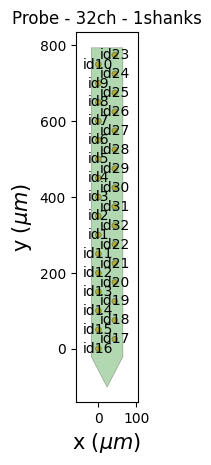

In [21]:
probe.create_auto_shape()
plot_probe(probe, with_contact_id=True)

(<matplotlib.collections.PolyCollection at 0x72e25c035610>,
 <matplotlib.collections.PolyCollection at 0x72e25c3ffb90>)

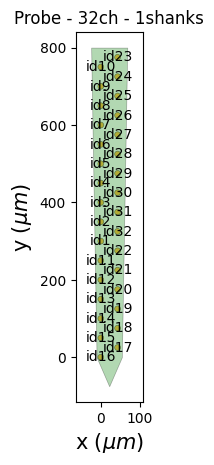

In [22]:
contour_polygon = [[-25, 800],
                   [-11, 0],
                   [43.3/2, -75.],
                   [54.3, 0],
                   [68.3, 800]]
probe.set_planar_contour(contour_polygon)
plot_probe(probe, with_contact_id=True)

## Step 3 : saving "probe unwired" into a json file

Using the function `write_probeinterface()`, you can save the probe to a file. Inspect the file and have a look to the way this is constructed.

In [23]:
pi.write_probeinterface('A1x32-Poly2-10mm-50s-177_unwired.json', probe)

In [24]:
# this is a Unix-style command. It won't work on Windows
!head -25 A1x32-Poly2-10mm-50s-177_unwired.json

# for Windows cmd prompt we can only use "more"
# but since Windows has 3 different terminal apps this depends on many factors which command will work
# !more -25 A1x32-Poly2-10mm-50s-177_unwired.json

{
    "specification": "probeinterface",
    "version": "0.2.24",
    "probes": [
        {
            "ndim": 2,
            "si_units": "um",
            "annotations": {},
            "contact_annotations": {},
            "contact_positions": [
                [
                    0.0,
                    300.0
                ],
                [
                    0.0,
                    350.0
                ],
                [
                    0.0,
                    400.0
                ],
                [
                    0.0,
                    450.0


## Step 4 : wiring to device channel (aka pathway or mapping)

Now lets do the "wiring" aka channel mapping. Lets connect our probe to an RHD2132 Intan headstage with the H32 connector.

You can get some help by looking at https://intantech.com/RHD_headstages.html?tabSelect=RHD32ch&yPos=0

And also, note that the mapping depends on the connector of the probe, see this https://www.neuronexus.com/files/probemapping/32-channel/H32-Maps.pdf


<img src="./Intan_RDH2132_overview.png" width="400"/>
<img src="./Intan_RDH2132_connector_pineout.png" width="400"/>
<img src="./H32_neuronexus_connector_omnetics.png" width="400"/>


Probeinterface has 2 ways to make the mapping:

 1. Manually with : `probe.set_device_channel_indices()`
 2. Automatically with `probe.wiring_to_device()`
 
  
Use the `with_contact_id=True` and `with_device_index=True` option for plot_probe. Check with dataframe the mapping.

It is **super important** to remember that the `channel_ids` and the `device_channel_indices` are not the same numbers so the mapping is the only way we can connect 
the position of an electrode contact and a row in the data matrix!!


(<matplotlib.collections.PolyCollection at 0x72e25c0d3aa0>,
 <matplotlib.collections.PolyCollection at 0x72e25c050650>)

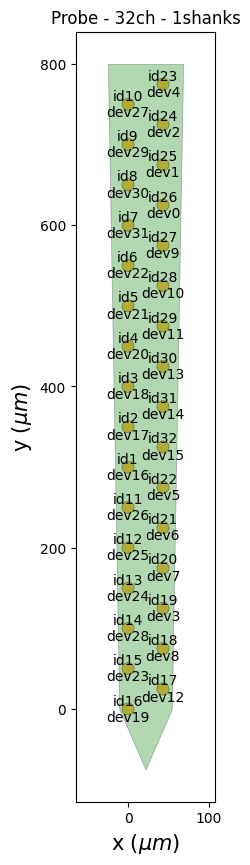

In [25]:
manual_mapping = [
    16, 17, 18, 20, 21, 22, 31, 30, 29, 27, 26, 25, 24, 28, 23, 19,
    12, 8, 3, 7, 6, 5, 4, 2, 1, 0, 9, 10, 11, 13, 14, 15]
probe.set_device_channel_indices(manual_mapping)
fig, ax = plt.subplots(figsize=(10,10))
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

Now the manual mapping required us to carefully link up those numbers, but feel free as an exercise to change the order of the mapping number and see how it changes the correspondance between `contact_ids` and `device_channel_indices`. Since we already have this mapping done automatically as an available pathway you can check to see the difference these changes make!

In [26]:
probe.to_dataframe(complete=True)

,x,y,contact_shapes,radius,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,0.0,300.0,circle,7.5,,1,16,um,1.0,0.0,0.0,1.0
1,0.0,350.0,circle,7.5,,2,17,um,1.0,0.0,0.0,1.0
2,0.0,400.0,circle,7.5,,3,18,um,1.0,0.0,0.0,1.0
3,0.0,450.0,circle,7.5,,4,20,um,1.0,0.0,0.0,1.0
4,0.0,500.0,circle,7.5,,5,21,um,1.0,0.0,0.0,1.0
5,0.0,550.0,circle,7.5,,6,22,um,1.0,0.0,0.0,1.0
6,0.0,600.0,circle,7.5,,7,31,um,1.0,0.0,0.0,1.0
7,0.0,650.0,circle,7.5,,8,30,um,1.0,0.0,0.0,1.0
8,0.0,700.0,circle,7.5,,9,29,um,1.0,0.0,0.0,1.0
9,0.0,750.0,circle,7.5,,10,27,um,1.0,0.0,0.0,1.0


(<matplotlib.collections.PolyCollection at 0x72e25c0e8ec0>,
 <matplotlib.collections.PolyCollection at 0x72e24f529310>)

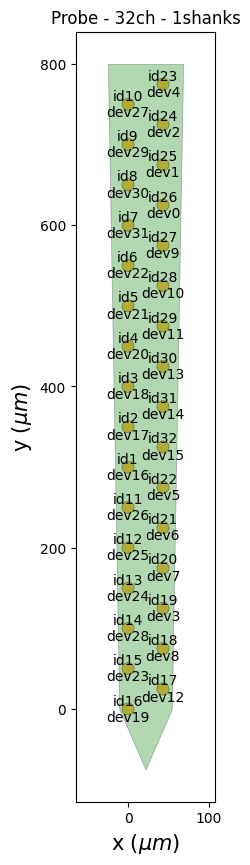

In [27]:
probe.wiring_to_device('H32>RHD2132')
fig, ax = plt.subplots(figsize=(10,10),)
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)


In [28]:
probe_df = probe.to_dataframe(complete=True)
probe_df

,x,y,contact_shapes,radius,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,0.0,300.0,circle,7.5,,1,16,um,1.0,0.0,0.0,1.0
1,0.0,350.0,circle,7.5,,2,17,um,1.0,0.0,0.0,1.0
2,0.0,400.0,circle,7.5,,3,18,um,1.0,0.0,0.0,1.0
3,0.0,450.0,circle,7.5,,4,20,um,1.0,0.0,0.0,1.0
4,0.0,500.0,circle,7.5,,5,21,um,1.0,0.0,0.0,1.0
5,0.0,550.0,circle,7.5,,6,22,um,1.0,0.0,0.0,1.0
6,0.0,600.0,circle,7.5,,7,31,um,1.0,0.0,0.0,1.0
7,0.0,650.0,circle,7.5,,8,30,um,1.0,0.0,0.0,1.0
8,0.0,700.0,circle,7.5,,9,29,um,1.0,0.0,0.0,1.0
9,0.0,750.0,circle,7.5,,10,27,um,1.0,0.0,0.0,1.0


## Step 5 : saving the "probe wired" into json

Now that the probe has been wired, let's save it into a file and inspect the resulting file

In [29]:
pi.write_probeinterface('A1x32-Poly2-10mm-50s-177_wired.json', probe)

In [30]:
!head -25 A1x32-Poly2-10mm-50s-177_unwired.json

# Again for Windows may need to test commands like !more or !type A1x32-Poly2-10mm-50s-177_unwired.json Head -20

{
    "specification": "probeinterface",
    "version": "0.2.24",
    "probes": [
        {
            "ndim": 2,
            "si_units": "um",
            "annotations": {},
            "contact_annotations": {},
            "contact_positions": [
                [
                    0.0,
                    300.0
                ],
                [
                    0.0,
                    350.0
                ],
                [
                    0.0,
                    400.0
                ],
                [
                    0.0,
                    450.0


### *Extra Feature: Probegroups*

These days many probes bought off the shelf come with multiple shanks. The probeinterface library handles this with the concept of Shanks and ProbeGroups.
In this case we have functions which mirror those that are important for probes. We can download a probe from a manufacturer and then set up a 
probegroup. For this example we will duplicate a an H6 from Cambridge Neurotech since this is a purchasing option.

In [31]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H6'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

ASSY-236-H6 - cambridgeneurotech - 64ch - 2shanks


We can easily just copy the probe and place it as it would be if you bought a stacked probe. First we indicate that this will be a 3d probe.

In [32]:
probe1 = probe.copy()
probe = probe.to_3d()
probe1 = probe1.to_3d()
probe1.move([0, 200, 0])

Now we setup our wiring. Let's say that we have a standard Intan 64 channel headstage with an omenetics connector.

In [33]:
wiring = pi.wiring.pathways["ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164"]
wiring_group = wiring + list(np.array(wiring)+64)

probegroup = pi.ProbeGroup()
probegroup.add_probe(probe)
probegroup.add_probe(probe1)
probegroup.set_global_device_channel_indices(wiring_group)
print(probegroup)

We can now plot our `probegroup`.We can look at it in 3d or look at each probe within the probe group on it's own set of axes with contact_ids

/tmp/ipykernel_26803/787080126.py:3: DeprecationWarning: `plot_probe_group` is deprecated and will be removed in 2.23. Use plot_probegroup instead
  plot_probe_group(probegroup)


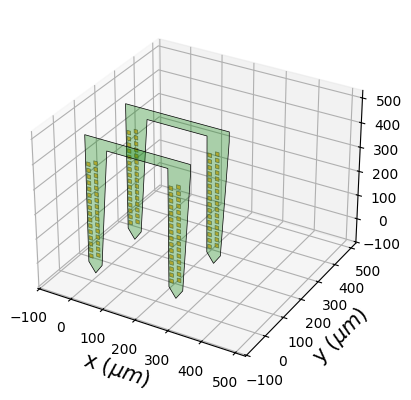

In [34]:
from probeinterface.plotting import plot_probe_group

plot_probe_group(probegroup)